#  Bias in Data

The code that I’m providing has been built mainly upon the following sources:
 
- https://fairmlbook.org/
- https://dalex.drwhy.ai/python-dalex-fairness.html
- https://dalex.drwhy.ai/python/
- https://www.kdnuggets.com/2020/12/machine-learning-model-fair.html
 
Unverified black box model is the path to the failure. Opaqueness leads to distrust. Distrust leads to ignoration. Ignoration leads to rejection.

The dalex package xrays any model and helps to explore and explain its behaviour, helps to understand how complex models are working. The main [Explainer](https://dalex.drwhy.ai/python/api/#dalex.Explainer) object creates a wrapper around a predictive model. Wrapped models may then be explored and compared with a collection of model-level and predict-level explanations. Moreover, there are fairness methods and interactive exploration dashboards available to the user.

The philosophy behind dalex explanations is described in the [Explanatory Model Analysis e-book](https://ema.drwhy.ai/).

In [1]:
# basic imports
import dalex as dx
import numpy as np

# import scikit-learn
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import plot_confusion_matrix

To showcase the problem of fairness in AI, we will be using the German Credit Data dataset to assign risk for each credit-seeker.
Information about this dataset can be found here: https://archive.ics.uci.edu/ml/datasets/statlog+(german+credit+data)

We will at first create a very simple ML model (decision tree) for the data. Additionally, we will use create random forest and logistic regression, but thes two models will be used later.

It is very important to avoid any bias, when a person applies for loan in bank, as nobody would want to be negatively affected, as well if the bank does not have reliable model, the bank can lose part of business or provide loans to people, that would not receive loans by unbiased models. 

The data we use for modeling is in the major part a reflection of the world it derives from. And as the world can be biased, so data and therefore model will likely reflect that. 

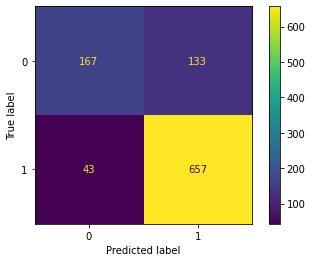

In [29]:
# load credit data
data = dx.datasets.load_german()

# risk is the target variable
features = data.drop(columns='risk')
labels = data.risk

# select few categorical and numerical features
categorical_features = ['sex', 'job', 'housing', 'saving_accounts', "checking_account", 'purpose']
numeric_features = ['credit_amount', 'age']

# create one hot encoder for categorical variables as transformer
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# scale numerical features as transformer
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features),
        ('num', numeric_transformer, numeric_features)])


# create a pipeline, containing the above transformer and decision tree
clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(max_depth=7, random_state=42))
])

# train decision tree on this data
clf.fit(features, labels)

# train also random forest - it will be used later
clf_forest = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', RandomForestClassifier(random_state=42, max_depth=5))]).fit(features,labels)

# trian also logistic regression - it will be used later
clf_logreg = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LogisticRegression(random_state=42))]).fit(features,labels)

# plot confusion matrix of decision tree
plot_confusion_matrix(clf, features, labels)

We create an Explainer object to showcase dalex functionalities. Then we look at the overal performance of our model. Even through its simple, it is not bad. At first, we will use only decision tree.

In [32]:
exp = dx.Explainer(clf, features, labels)
exp.model_performance().result

Preparation of a new explainer is initiated

  -> data              : 1000 rows 9 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 1000 values
  -> model_class       : sklearn.tree._classes.DecisionTreeClassifier (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function yhat_proba_default at 0x7efd931253a0> will be used (default)
  -> predict function  : Accepts only pandas.DataFrame, numpy.ndarray causes problems.
  -> predicted values  : min = 0.0, mean = 0.7, max = 1.0
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.944, mean = 8.88e-19, max = 0.923
  -> model_info        : package sklearn

A new explainer has been created!


,recall,precision,f1,accuracy,auc
DecisionTreeClassifier,0.941429,0.829975,0.882195,0.824,0.883371


To check if the model is biased, we will use the fairness module from dalex. Checking if the model is fair should be straightforward. Apart from the dx.Explainer, we will need 2 parameters:

- protected - array-like of subgroups values that denote a sensitive attribute (protected variable) like sex, nationality etc. The fairness metrics will be calculated for each of those subgroups and compared.
- privileged - a string representing one of the subgroups. It should be the one suspected of the most privilege.

The idea here is that ratios between scores of privileged and unprivileged metrics should be close to 1. The closer the more fair the model is. But to relax this criterion a little bit, it can be written more thoughtfully:

$\forall_{i \varepsilon \{a,b,...,z\}}  \epsilon  \frac{metrix_i}{metric_{privileged}} < \frac{1}{\epsilon}$

where the epsilon is a value between 0 and 1. It should be a minimum acceptable ratio. On default, it is 0.8, which adheres to [four-fifths rule (80% rule)](https://www.hirevue.com/blog/hiring/what-is-adverse-impact-and-why-measuring-it-matters) commonly used. Of course, a user may change this value to their needs.

In [36]:
# array with values like male_old, female_young, etc.
protected = data.sex + '_' + np.where(data.age < 25, 'young', 'old')

privileged = 'male_old'  # we assume, that older males are prviliged compared to young females, lets thest this hypothesis

fobject = exp.model_fairness(protected = protected, privileged = privileged)
fobject.fairness_check(epsilon = 0.8)

Bias detected in 3 metrics: TPR, FPR, STP

Conclusion: your model is not fair because 2 or more criteria exceeded acceptable limits set by epsilon.

Ratios of metrics, based on 'male_old'. Parameter 'epsilon' was set to 0.8 and therefore metrics should be within (0.8, 1.25)
                   TPR       ACC       PPV       FPR       STP
female_old    1.019771  0.981020  0.952719  1.022822  0.986811
female_young  0.736733  0.832740  0.893617  0.634855  0.642686
male_young    0.884495  0.931198  0.957447  0.663900  0.774580


This model should not be called fair. Generally, each metric should be between (epsilon, 1/epsilon). Metrics are calculated for each subgroup, and then their scores are divided by the score of the privileged subgroup. That is why we omit male_old in this method. When at least 2 metrics have scores ratio outside of the epsilon range, dalex declared this model unfair. In our case it cannot be decided automatically but the bias is visible and FPR (False Positive Rate) is especially important in case of risk assigning, so let's call our model unfair.

The bias was spotted in metric FPR, which is the False Positive Rate. The output above suggests that the model cannot be automatically approved (like said in the output above). So it is up to the user to decide. In my opinion, it is not a fair model. Lower FPR means that the privileged subgroup is getting False Positives more frequently than the unprivileged.

## Let's check more metrics

We get the information about bias, the conclusion, and metrics ratio raw DataFrame. There are metrics TPR (True Positive Rate), ACC (Accuracy), PPV (Positive Predictive Value), FPR (False Positive Rate), STP(Statistical parity). The metrics are derived from a confusion matrix for each unprivileged subgroup and then divided by metric values based on the privileged subgroup. 

The result attribute is metric_scores where each row is divided by row indexed with privileged (in this case male_old).

In [37]:
fobject.result # to see all scaled metric values

,TPR,TNR,PPV,NPV,FNR,FPR,FDR,FOR,ACC,STP
female_old,1.019771,0.978764,0.952719,1.118501,0.512821,1.022822,1.259740,0.433526,0.981020,0.986811
female_young,0.736733,1.339768,0.893617,0.775091,7.487179,0.634855,1.584416,2.075145,0.832740,0.642686
male_old,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
male_young,0.884495,1.312741,0.957447,0.893591,3.846154,0.663900,1.233766,1.508671,0.931198,0.774580


In [38]:
fobject.metric_scores # or unscaled ones

,TPR,TNR,PPV,NPV,FNR,FPR,FDR,FOR,ACC,STP
female_old,0.980,0.507,0.806,0.925,0.020,0.493,0.194,0.075,0.827,0.823
female_young,0.708,0.694,0.756,0.641,0.292,0.306,0.244,0.359,0.702,0.536
male_old,0.961,0.518,0.846,0.827,0.039,0.482,0.154,0.173,0.843,0.834
male_young,0.850,0.680,0.810,0.739,0.150,0.320,0.190,0.261,0.785,0.646


## Let's look at some plot (dalex uses plotly)

There are two bias detection plots available (however, there are more ways to visualize bias in the package)

- fairness_check— visualization of fairness_check() method
- metric_scores— visualization of metric_scores attribute which is raw scores of metrics.

For fairness_check, if a bar reaches the red field, it means that for this metric model is exceeding the (epsilon, 1/epsilon) range. In this case the DecisionTreeClassifier has one NaN. In this case appropriate message is given (it can be disabled with verbose=False).

For metric_scores, vertical lines showcase the score of the privileged subgroup. Points closer to the line indicate less bias in the model.

In [39]:
fobject.plot()

Unsupported

In [40]:
fobject.plot(type = 'metric_scores')

Unsupported

## Multiple models

Let's now use also random forest and logistic regression results.

In [42]:
# create Explainer objects 
exp_forest  = dx.Explainer(clf_forest, features, labels, verbose = False)
exp_logreg  = dx.Explainer(clf_logreg, features, labels, verbose = False)

# create fairness explanations
fobject_forest = exp_forest.model_fairness(protected, privileged)
fobject_logreg = exp_logreg.model_fairness(protected, privileged)

# fairness check
fobject_forest.fairness_check(epsilon = 0.8)
fobject_logreg.fairness_check(epsilon = 0.8)

Bias detected in 2 metrics: FPR, STP

Conclusion: your model is not fair because 2 or more criteria exceeded acceptable limits set by epsilon.

Ratios of metrics, based on 'male_old'. Parameter 'epsilon' was set to 0.8 and therefore metrics should be within (0.8, 1.25)
                   TPR       ACC       PPV       FPR       STP
female_old    0.990900  0.974684  0.962963  0.884058  0.949353
female_young  0.884732  0.903797  0.893997  0.658762  0.769397
male_young    0.985844  0.915190  0.888889  0.895916  0.928879
Bias detected in 3 metrics: TPR, FPR, STP

Conclusion: your model is not fair because 2 or more criteria exceeded acceptable limits set by epsilon.

Ratios of metrics, based on 'male_old'. Parameter 'epsilon' was set to 0.8 and therefore metrics should be within (0.8, 1.25)
                   TPR       ACC       PPV       FPR       STP
female_old    0.917109  0.944954  0.971831  0.788752  0.870056
female_young  0.774708  0.889908  0.914213  0.533608  0.658757
male_young    

In [43]:
fobject.plot(objects=[fobject_forest, fobject_logreg])

Unsupported

In [44]:
fobject.plot(objects=[fobject_forest, fobject_logreg], type = "radar")

Unsupported

## Metrics


| Metric | Formula | Full name | fairness names while checking among subgroups |
| ----------- | ----------- | ----------- | ----------- |
| TPR | $\frac{TP}{TP+FN}$ | true positive rate | equal opportunity |
| TNR | $\frac{TN}{TP+FP}$ | true negative rate |  |
| PPV | $\frac{TP}{TP+FP}$ | positive predictive value |  |
| NPV | $\frac{TN}{TN+FN}$ | negative predictive value |  |
| FNR | $\frac{FP}{FN+TP}$ | false negative rate	 |  |
| FPR | $\frac{FN}{FP+TN}$ | false positive rate	 | predictive equality |
| FDR | $\frac{FP}{FP+TP}$ | false discovery rate |  |
| FOR | $\frac{FN}{FN+TN}$ | false ommision rate |  |
| TS |  $\frac{TP}{TP+FN+FP}$ | threat score |  |
| STP | $\frac{TP+FP}{TP+FN+FP+TN}$ | statistical parity | statistical parity |
| ACC | $\frac{TP+TN}{TP+FN+FP+TN}$ | accuracy | overall accuracy equality |
| F1 | $2\cdot \frac{PPV*TPR}{PPV-TPR}$ | f1 score |  |